# Model Training Notebook

The following notebook contains the code we used to perform our model training. The includes training logistic regression and random forest models on a training (development) set of data, selecting appropriate hyperparameters for our random forest model, and examining both models' performances on the training set.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

#Training - Baseline

The following cell will load in the pre-processed training and validation datasets as pandas dataframes. The column containing the final label (`'healed12'`) is removed from the input data and saved as a seperated dataframe. We also remove any entries derivared from data past the baseline (initial) patient visit.

In [ ]:
# load data
x_Tr = pd.read_csv('/content/drive/MyDrive/wound care data/train_35_final.csv')
y_Tr = x_Tr['healed12']
x_Tr = x_Tr.drop(['healed12'], axis=1)

In [ ]:
# drop all columns past baseline

to_keep = set(x_Tr.columns)

for key in x_Tr.columns:
  for i in range(1, 6):
    if '_' + str(i * 7) in key or '_D' in key:
      to_keep.discard(key)

print(to_keep)
x_Tr = x_Tr[list(to_keep)]

The next cell trains a logistic regression model to predict wound healing within 12 weeks, using data available at a patient's initial visit to the wound care clinic.



In [ ]:
# train logistic regression model
# increased maximum iteration to 1000 since did not converge at default number

log_reg_model_0 = LogisticRegression(max_iter=1000).fit(x_Tr, y_Tr)

We then examine model performance on the training data by calculating accuracy, precision, sensitivity, and specificty. ROC curves are also included later in this section.

In [ ]:
preds = log_reg_model_0.predict(x_Tr)

In [ ]:
print("The accuracy is {}".format(accuracy_score(y_Tr, preds)))
print("The precision is {}".format(precision_score(y_Tr, preds)))
print("The recall is {}".format(recall_score(y_Tr, preds)))

The accuracy is 0.6906686400420138
The precision is 0.7045662660632057
The recall is 0.8438497847208193


Next, we will also train a Random Forest on the same prediction task. To find a good set of hyperparameters for our Random Forest, we create a grid to search over and then use 3-fold cross validation to select our hyperparameters.

In [ ]:
# create hyperparameter search grid

# Number of trees in random forest
n_estimators = [10, 20, 50, 75, 100, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 70, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 50, 75, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 19, 36, 53, 70, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf_0 = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 30 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_0, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_Tr, y_Tr)

In [ ]:
rf_model = rf_random.best_estimator_

In [ ]:
rf_random.best_params_

{'n_estimators': 75,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 19,
 'bootstrap': False}

The following cell contains the selected hyperparameters as a reference.

In [ ]:
rf_model_0 = RandomForestClassifier(n_estimators = 75,
 min_samples_split = 10,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = 19,
 bootstrap = False)

In [ ]:
rf_model_0.fit(x_Tr, y_Tr)

We repeat the same calculations as above for the Logistic Regression model for the Random Forest model as well.

In [ ]:
preds = rf_model_0.predict(x_Tr)

In [ ]:
print("The accuracy is {}".format(accuracy_score(y_Tr, preds)))
print("The precision is {}".format(precision_score(y_Tr, preds)))
print("The recall is {}".format(recall_score(y_Tr, preds)))

The accuracy is 0.8021341099520183
The precision is 0.7891128278682065
The recall is 0.9195215318537099


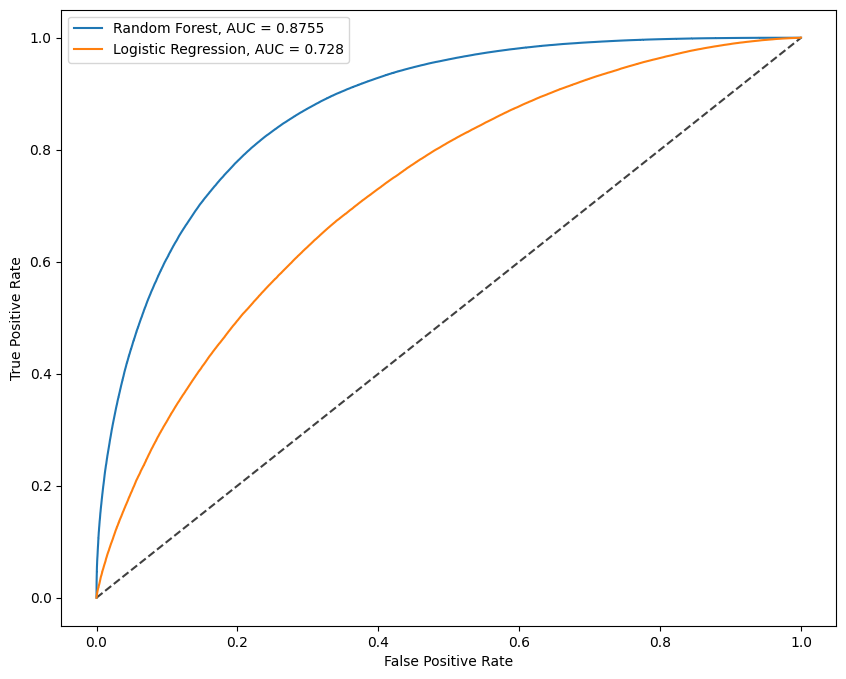

In [ ]:
#set up plotting area
plt.figure(0).clf()

plt.gcf().set_size_inches(10,8)

# add random forest model results
y_pred = rf_model_0.predict_proba(x_Tr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_Tr, y_pred)
auc = round(metrics.roc_auc_score(y_Tr, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC = "+str(auc))

# add logistic regression model results
y_pred = log_reg_model_0.predict_proba(x_Tr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_Tr, y_pred)
auc = round(metrics.roc_auc_score(y_Tr, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC = "+str(auc))

lims = [0, 1]

# now plot both limits against eachother
plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#add legend
plt.legend()

#plt.savefig('/content/drive/MyDrive/wound care data/ROC_baseline_training.png', bbox_inches='tight', dpi=600, facecolor='white')

Finally, we also examine the Random Forest feature importances to determine what information our model is using to make its predictions.

In [ ]:
# calculate feature importances

importances = rf_model_0.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_0.estimators_], axis=0)
forest_importances = pd.Series(importances, index=x_Tr.columns)
forest_importances = forest_importances.sort_values(ascending=False)

forest_importances

Area_0                      0.215920
Depth_0                     0.149874
durationcat                 0.062817
Wound_Count_Cat             0.056457
Location_Lower Leg          0.042832
Stage_Partial thickness     0.035928
Location_Foot               0.030407
agecat                      0.029074
bmicat                      0.028135
Type_Other                  0.025683
Stage_Unknown               0.019594
Type_Venous Ulcer           0.019237
PVD_c                       0.017326
Type_Pressure Ulcer         0.015935
Type_Arterial Ulcer         0.015581
Necrotic_0                  0.015212
Palliative                  0.014650
Stage_Full thickness        0.014425
Gender                      0.013832
diabetes_c                  0.013622
Hypertension                0.012176
Infected_0                  0.011562
CHF_c                       0.011437
CAD_c                       0.011378
Location_Toe                0.011323
HeavyExudate_0              0.011045
COPD_c                      0.010698
S

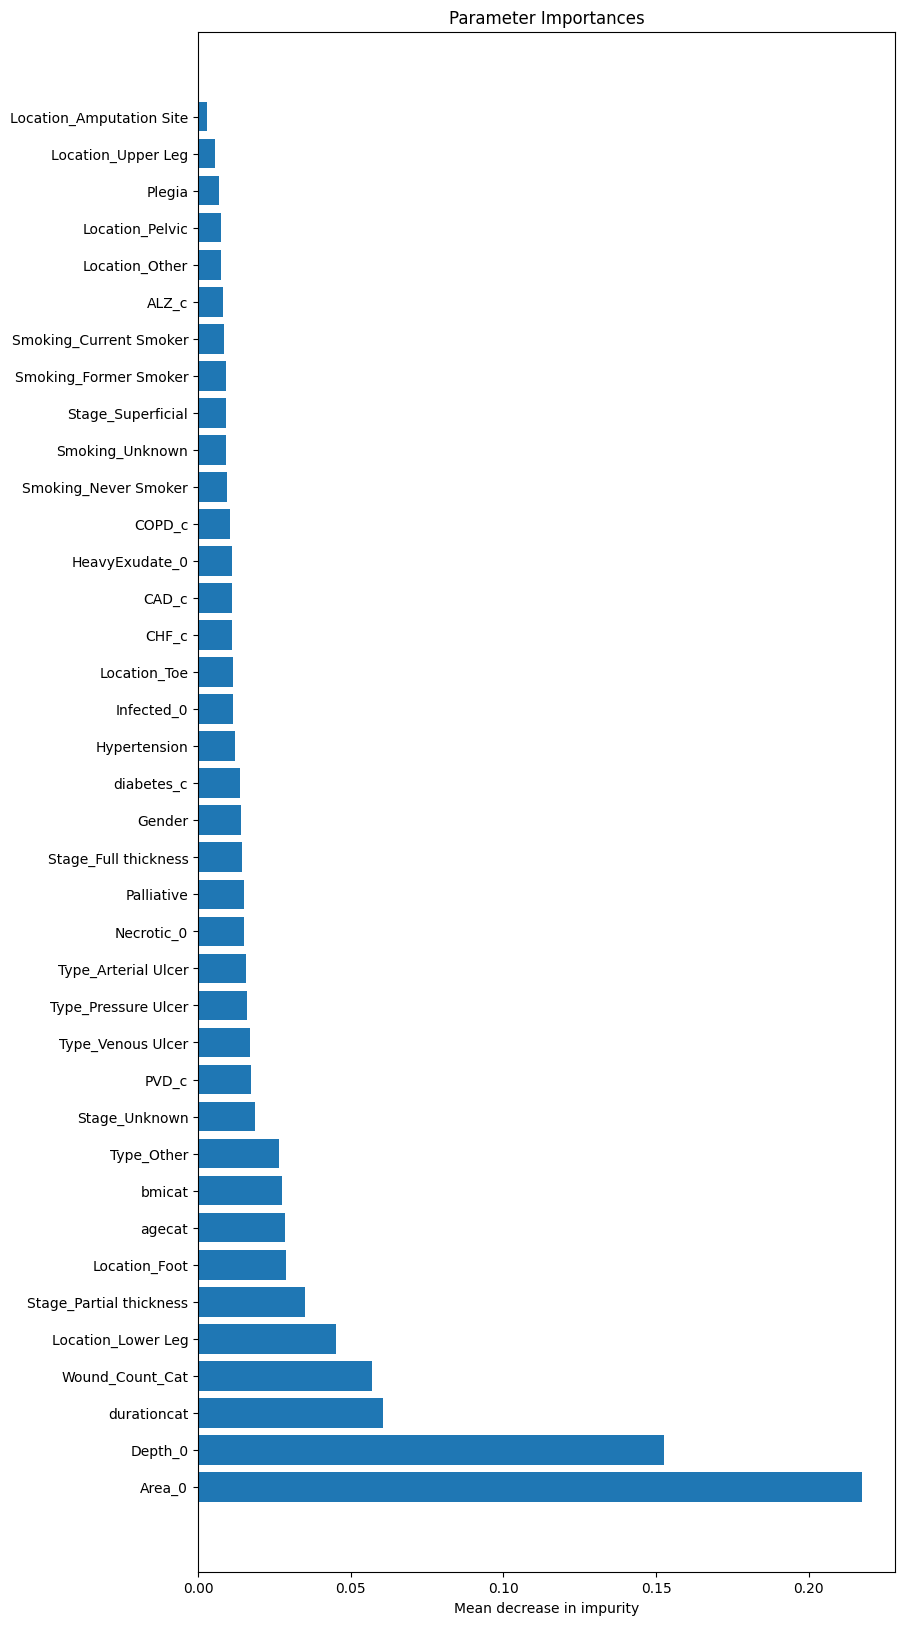

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.barh(forest_importances.index, forest_importances[forest_importances.index].values)

plt.gcf().set_size_inches(9,20)

plt.title("Parameter Importances")
plt.xlabel("Mean decrease in impurity")

plt.show()

#Training - Day 28

This section includes the training details for training models to predicit a wound healing within 12 weeks, using data from the first 28 days after a patient's initial visit. For a more detailed description of each of the cells, please refer to the previous section ('Training - Baseline') as the procedure is the same for each timepoint.

In [ ]:
# load data
x_Tr = pd.read_csv('/content/drive/MyDrive/wound care data/train_28_final.csv')
y_Tr = x_Tr['healed12']
x_Tr = x_Tr.drop(['healed12'], axis=1)

In [ ]:
# train logistic regression model
# increased maximum iteration to 1000 since did not converge at default number

log_reg_model = LogisticRegression(max_iter=1000).fit(x_Tr, y_Tr)

In [ ]:
preds = log_reg_model.predict(x_Tr)

In [ ]:
print("The accuracy is {}".format(accuracy_score(y_Tr, preds)))
print("The precision is {}".format(precision_score(y_Tr, preds)))
print("The recall is {}".format(recall_score(y_Tr, preds)))

The accuracy is 0.7627581792272878
The precision is 0.7619810889021955
The recall is 0.8862243736064697


In [ ]:
# create hyperparameter search grid

# Number of trees in random forest
n_estimators = [10, 20, 50, 75, 100, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 70, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 50, 75, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 19, 36, 53, 70, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 30 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_Tr, y_Tr)

In [ ]:
rf_model = rf_random.best_estimator_

In [ ]:
rf_random.best_params_

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 100,
 min_samples_split = 5,
 min_samples_leaf = 8,
 max_features = 'sqrt',
 max_depth = 36,
 bootstrap = False)

In [ ]:
rf_model.fit(x_Tr, y_Tr)

In [ ]:
preds = rf_model.predict(x_Tr)

In [ ]:
print("The accuracy is {}".format(accuracy_score(y_Tr, preds)))
print("The precision is {}".format(precision_score(y_Tr, preds)))
print("The recall is {}".format(recall_score(y_Tr, preds)))

The accuracy is 0.9240154529575816
The precision is 0.9484272188321137
The recall is 0.9252061498048395


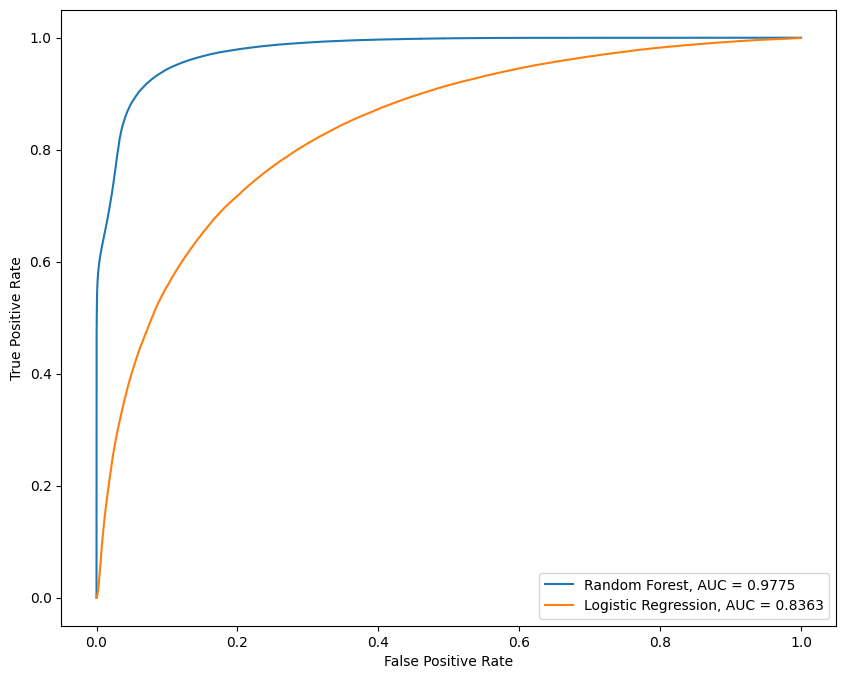

In [ ]:
#set up plotting area
plt.figure(0).clf()

plt.gcf().set_size_inches(10,8)

# add random forest model results
y_pred = rf_model.predict_proba(x_Tr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_Tr, y_pred)
auc = round(metrics.roc_auc_score(y_Tr, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC = "+str(auc))

# add logistic regression model results
y_pred = log_reg_model.predict_proba(x_Tr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_Tr, y_pred)
auc = round(metrics.roc_auc_score(y_Tr, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC = "+str(auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#add legend
plt.legend()

plt.show()

In [ ]:
# calculate feature importances

importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=x_Tr.columns)
forest_importances = forest_importances.sort_values(ascending=False)

forest_importances

RelChangeArea_0_7           0.112907
RelChangeArea_14_21         0.072588
RelChangeDepth_0_7          0.068768
RelChangeArea_7_14          0.065505
RelChangeArea_21_28         0.052702
                              ...   
Palliative                  0.000486
Location_Upper Leg          0.000485
ALZ_c                       0.000270
Plegia                      0.000206
Location_Amputation Site    0.000074
Length: 67, dtype: float64

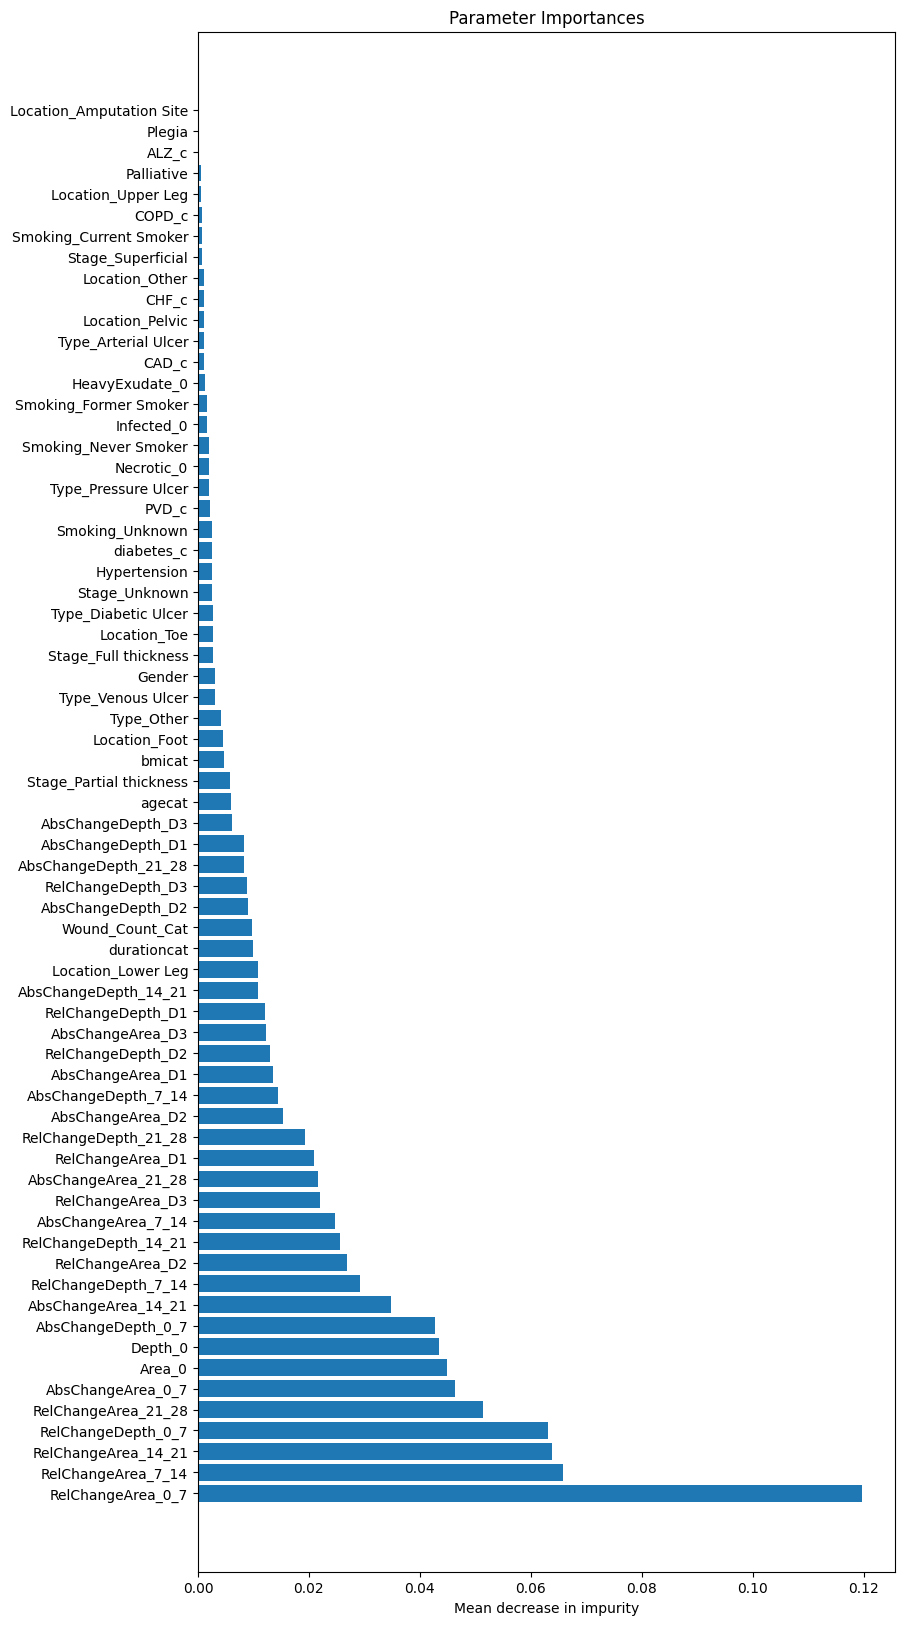

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.barh(forest_importances.index, forest_importances[forest_importances.index].values)

plt.gcf().set_size_inches(9,20)

plt.title("Parameter Importances")
plt.xlabel("Mean decrease in impurity")


#Training - Day 14

This section includes the training details for training models to predicit a wound healing within 12 weeks, using data from the first 14 days after a patient's initial visit. For a more detailed description of each of the cells, please refer to the firest section ('Training - Baseline') as the procedure is the same for each timepoint.

In [ ]:
# load data
x_Tr = pd.read_csv('/content/drive/MyDrive/wound care data/train_14_final.csv')
y_Tr = x_Tr['healed12']
x_Tr = x_Tr.drop(['healed12'], axis=1)

In [ ]:
# train logistic regression model
# increased maximum iteration to 1000 since did not converge at default number

log_reg_model = LogisticRegression(max_iter=1000).fit(x_Tr, y_Tr)

In [ ]:
preds = log_reg_model.predict(x_Tr)

In [ ]:
print("The accuracy is {}".format(accuracy_score(y_Tr, preds)))
print("The precision is {}".format(precision_score(y_Tr, preds)))
print("The recall is {}".format(recall_score(y_Tr, preds)))

The accuracy is 0.7326957231734423
The precision is 0.7391594747615
The recall is 0.8746313896010085


In [ ]:
# create hyperparameter search grid

# Number of trees in random forest
n_estimators = [10, 20, 50, 75, 100, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 70, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 50, 75, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 19, 36, 53, 70, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 30 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_Tr, y_Tr)

In [ ]:
rf_model = rf_random.best_estimator_

In [ ]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 53,
 'bootstrap': True}

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 100,
 min_samples_split = 5,
 min_samples_leaf = 8,
 max_features = 'sqrt',
 max_depth = 36,
 bootstrap = False)

In [ ]:
rf_model.fit(x_Tr, y_Tr)

In [ ]:
preds = rf_model.predict(x_Tr)

In [ ]:
print("The accuracy is {}".format(accuracy_score(y_Tr, preds)))
print("The precision is {}".format(precision_score(y_Tr, preds)))
print("The recall is {}".format(recall_score(y_Tr, preds)))

The accuracy is 0.8900436510567324
The precision is 0.8956121012365351
The recall is 0.92984434089203


In [ ]:
#set up plotting area
plt.figure(0).clf()

plt.gcf().set_size_inches(10,8)

# add random forest model results
y_pred = rf_model.predict_proba(x_Tr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_Tr, y_pred)
auc = round(metrics.roc_auc_score(y_Tr, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC = "+str(auc))

# add logistic regression model results
y_pred = log_reg_model.predict_proba(x_Tr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_Tr, y_pred)
auc = round(metrics.roc_auc_score(y_Tr, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC = "+str(auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#add legend
plt.legend()


In [ ]:
# calculate feature importances

importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=x_Tr.columns)
forest_importances = forest_importances.sort_values(ascending=False)

forest_importances

RelChangeArea_0_7           0.179227
RelChangeArea_7_14          0.091970
AbsChangeArea_0_7           0.083511
Area_0                      0.079042
RelChangeDepth_0_7          0.072136
Depth_0                     0.055840
AbsChangeDepth_0_7          0.042253
AbsChangeArea_7_14          0.041935
RelChangeDepth_7_14         0.036827
RelChangeArea_D1            0.036216
AbsChangeArea_D1            0.026448
durationcat                 0.021191
Wound_Count_Cat             0.021180
RelChangeDepth_D1           0.018078
Location_Lower Leg          0.017749
AbsChangeDepth_7_14         0.013319
agecat                      0.012789
Location_Foot               0.012512
Stage_Partial thickness     0.010631
AbsChangeDepth_D1           0.010446
bmicat                      0.009167
Type_Other                  0.009108
Type_Venous Ulcer           0.007365
Gender                      0.006222
Stage_Unknown               0.005415
PVD_c                       0.005180
Stage_Full thickness        0.005123
L

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.barh(forest_importances.index, forest_importances[forest_importances.index].values)

plt.gcf().set_size_inches(9,20)

plt.title("Parameter Importances")
plt.xlabel("Mean decrease in impurity")


#Training - Day 21

In [ ]:
# load data
x_Tr = pd.read_csv('/content/drive/MyDrive/wound care data/train_21_final.csv')
y_Tr = x_Tr['healed12']
x_Tr = x_Tr.drop(['healed12'], axis=1)

In [ ]:
log_reg_model = LogisticRegression(max_iter=1000).fit(x_Tr, y_Tr)

In [ ]:
preds = log_reg_model.predict(x_Tr)

In [ ]:
print("The accuracy is {}".format(accuracy_score(y_Tr, preds)))
print("The precision is {}".format(precision_score(y_Tr, preds)))
print("The recall is {}".format(recall_score(y_Tr, preds)))

The accuracy is 0.7484610156966502
The precision is 0.7510780771797408
The recall is 0.8804475663310998


In [ ]:
# create hyperparameter search grid

# Number of trees in random forest
n_estimators = [10, 20, 50, 75, 100, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 70, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 50, 75, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 19, 36, 53, 70, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 30 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_Tr, y_Tr)

In [ ]:
rf_model = rf_random.best_estimator_

In [ ]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 53,
 'bootstrap': True}

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 200,
 min_samples_split = 2,
 min_samples_leaf = 8,
 max_features = 'sqrt',
 max_depth = 53,
 bootstrap = False)

In [ ]:
rf_model.fit(x_Tr, y_Tr)

In [ ]:
preds = rf_model.predict(x_Tr)

In [ ]:
print("The accuracy is {}".format(accuracy_score(y_Tr, preds)))
print("The precision is {}".format(precision_score(y_Tr, preds)))
print("The recall is {}".format(recall_score(y_Tr, preds)))

The accuracy is 0.8676275559015841
The precision is 0.8928061406640485
The recall is 0.8904363448030298


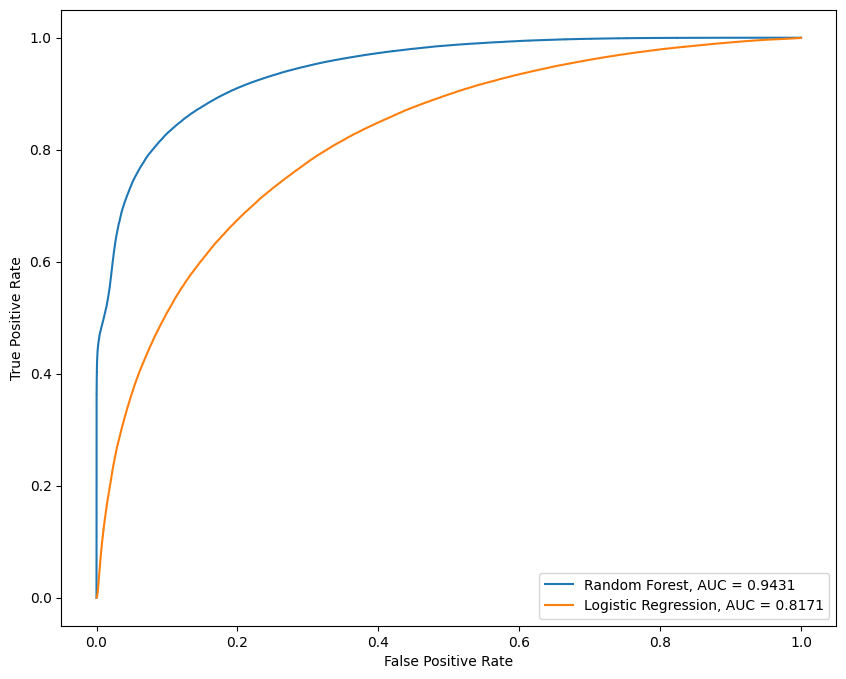

In [ ]:
#set up plotting area
plt.figure(0).clf()

plt.gcf().set_size_inches(10,8)

# add random forest model results
y_pred = rf_model.predict_proba(x_Tr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_Tr, y_pred)
auc = round(metrics.roc_auc_score(y_Tr, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC = "+str(auc))

# add logistic regression model results
y_pred = log_reg_model.predict_proba(x_Tr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_Tr, y_pred)
auc = round(metrics.roc_auc_score(y_Tr, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC = "+str(auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#add legend
plt.legend()


In [ ]:
# calculate feature importances

importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=x_Tr.columns)
forest_importances = forest_importances.sort_values(ascending=False)

forest_importances

RelChangeArea_0_7           0.139518
RelChangeArea_7_14          0.075007
RelChangeArea_14_21         0.065604
RelChangeDepth_0_7          0.064741
AbsChangeArea_0_7           0.063269
Area_0                      0.058841
Depth_0                     0.050169
AbsChangeDepth_0_7          0.042004
AbsChangeArea_7_14          0.036885
RelChangeDepth_7_14         0.036468
AbsChangeArea_14_21         0.031060
RelChangeArea_D1            0.028018
RelChangeArea_D2            0.027478
RelChangeDepth_14_21        0.023777
AbsChangeArea_D1            0.020158
AbsChangeArea_D2            0.017940
RelChangeDepth_D1           0.015168
durationcat                 0.015119
Wound_Count_Cat             0.014336
AbsChangeDepth_7_14         0.013645
Location_Lower Leg          0.013402
AbsChangeDepth_D1           0.012979
AbsChangeDepth_14_21        0.012438
RelChangeDepth_D2           0.011186
agecat                      0.008377
Location_Foot               0.008314
AbsChangeDepth_D2           0.008094
S

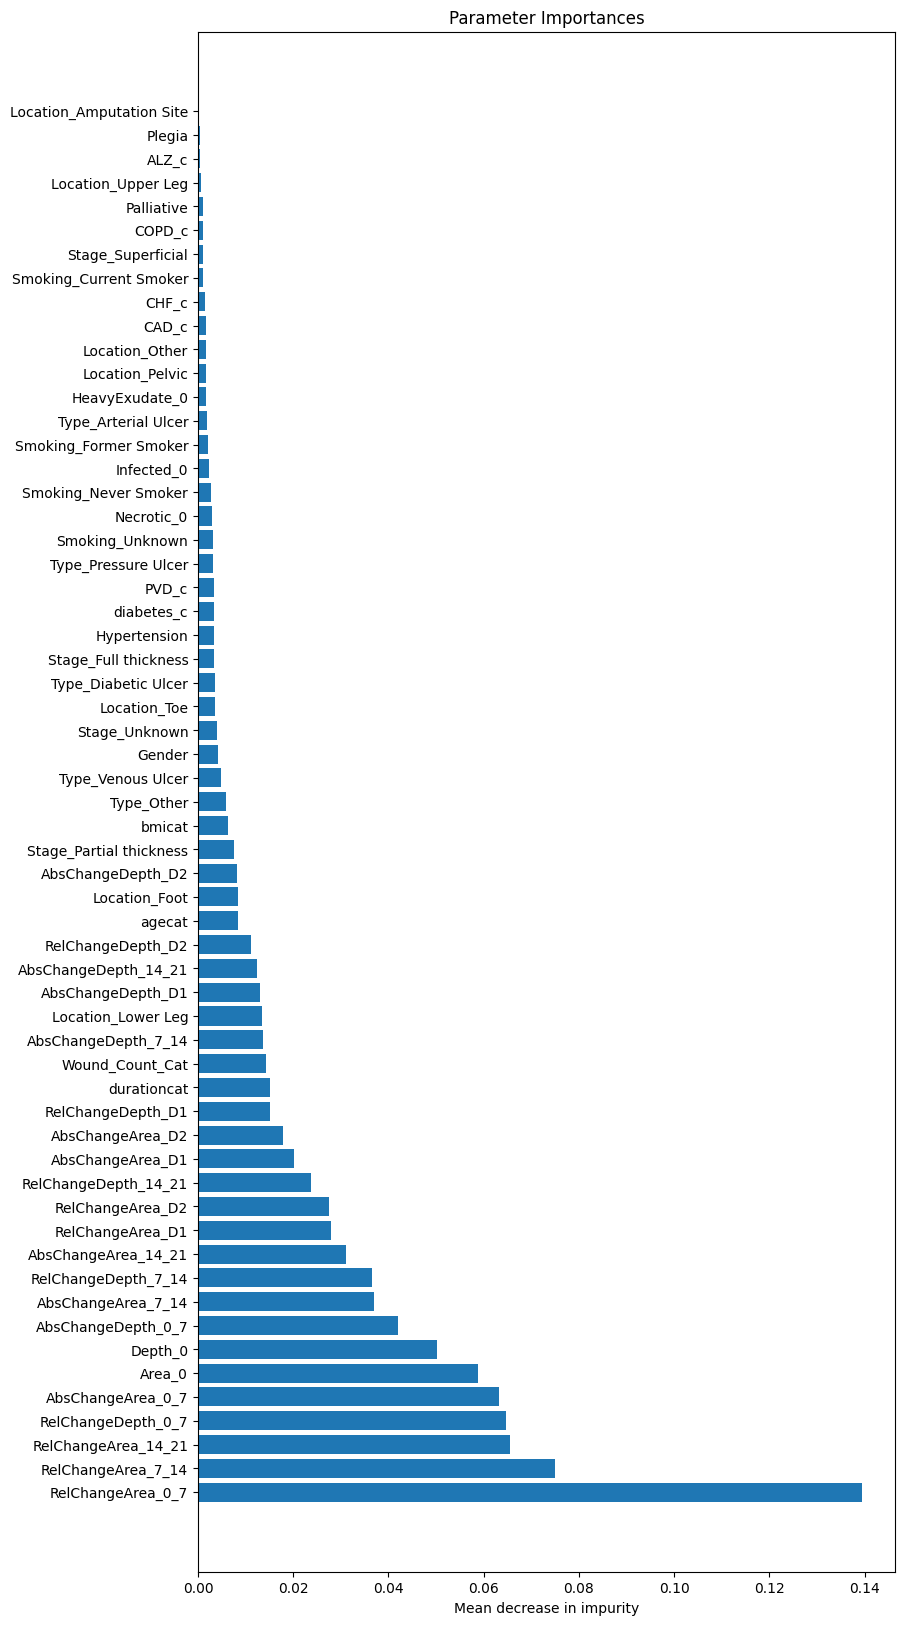

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.barh(forest_importances.index, forest_importances[forest_importances.index].values)

plt.gcf().set_size_inches(9,20)

plt.title("Parameter Importances")
plt.xlabel("Mean decrease in impurity")
